# Generating visibilities from custom true sky image

This notebook aim to generate **visibilities** $V(u,v,w)$ from custom **true sky image** $I(l,m)$ with the standard **dataflow degridding** method.

- The **true sky image** is a `GRID_SIZE`x`GRID_SIZE` grid projected in the celestial plan $(l,m)$ a.k.a spatial domain.
- The **visibilities** $V(u,v,w)$ are measured in the $u,v$ space a.k.a the Fourier (spectral) domain.

The process of transforming a **gridded sky image** into **visibilities** is called **degridding**. It consists of interpolating the sampled uv-coordinates from the discretized Fourier transform of the image. This is the inverse operation of gridding, which maps measured visibilities onto a uniform grid before applying an FFT to reconstruct an image.

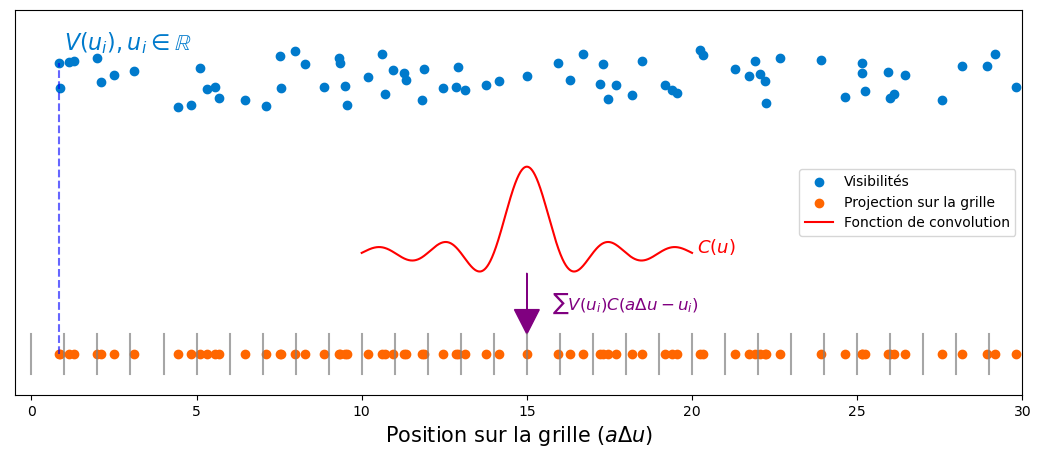

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def kaiser_bessel_kernel(x, alpha=0.5, a=5):
    return np.sinc(x) * np.i0(alpha * np.sqrt(1 - (x/a)**2))

# Paramètres de la grille et des visibilités
N = 30  # Nombre de points sur la grille
dx = 1  # Pas de la grille
a = np.arange(N)  # Indices de la grille
M = 75  # Nombre de visibilités

# Position du point de convolution
center_pos = (N // 2) * dx
conv_half_width = 5 * dx
conv_x = np.linspace(-conv_half_width, conv_half_width, 1000)

# Génération des visibilités aléatoires
vis_x = np.sort(np.random.rand(M) * N * dx)
vis_values = 1.5 + np.random.rand(M) * 0.7 + 0.3

# Création de la figure
plt.figure(figsize=(13, 5))
ax = plt.axes()
ax.axes.get_yaxis().set_visible(False)

# Affichage de la grille
for x in a * dx:
    plt.plot([x, x], [-1.5, -1.0], color='gray', linestyle='-', alpha=0.7)

# Affichage des visibilités
plt.scatter(vis_x, vis_values, color='#007acc', label='Visibilités')
plt.scatter(vis_x, np.ones(M) * -1.25, color='#ff6600', label='Projection sur la grille')
plt.plot([vis_x[0], vis_x[0]], [-1.25, vis_values[0]], 'b--', alpha=0.6)

# Affichage du kernel de convolution (Kaiser-Bessel)
plt.plot(center_pos + conv_x, kaiser_bessel_kernel(conv_x), color='red', label='Fonction de convolution')

# Texte explicatif
plt.text(center_pos + 0.75, -0.70, r"$\sum{V(u_i)C(a\Delta{u}-u_i)}$", fontsize=12, color='purple')
plt.text(center_pos + conv_half_width + 0.15, 0, "$C(u)$", fontsize=13, color='red')
plt.text(1, 2.5, r"$V(u_i), u_i \in \mathbb{R}$", fontsize=16, color='#007acc')
plt.arrow(center_pos, -0.25, 0, -0.45, head_width=0.75, head_length=0.3, fc='purple', ec='purple')

# Ajustements des axes
plt.ylim(-1.75, 3.0)
plt.xlim(-0.5 * dx, N * dx)
plt.xlabel(r"Position sur la grille ($a\Delta{u}$)", fontsize=15)
plt.legend()
plt.show()

*This figure illustrates the gridding process in one dimension. The visibility function, sampled at irregular positions (blue dots), is projected onto a regular grid (orange dots). The black vertical bars indicate the grid points where values are stored. The convolution function, represented here by the red curve (Kaiser-Bessel kernel), is applied to approximate the continuous visibility function on the grid. The convolution process is represented by the summation formula in purple.*


In [18]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    A["True Sky I(l,m)"] --> B["Degridding"];
    D["Interferometer Config (kernel + uvw coord)"] --> B["Degridding"];
    B --> C["Visibility V(u,v,w)"];
""")



## `std_degridding()` principle
Degridding is a key stage in the imaging process, where the values of a regular grid are interpolated to irregular points (the visibilities).

#### 🔎 The std_degridding consist in:
- Take an `input_grid` containing the transformed data.
- Extract (interpolate) the values at specific positions defined by the `corrected_vis_uvw_coords`.
- Apply a correction via an interpolation `kernel`.
- Store the result in `output_visibilities`.


#### 🧱 Function parameters:

```c
void std_degridding(
 int GRID_SIZE, // Grid size (GRID_SIZE x GRID_SIZE)
 int NUM_VISIBILITIES, // Total number of visibilities to process
 //int NUM_KERNELS, // Total number of kernels available
 //int TOTAL_KERNEL_SAMPLES,          // Total number of samples in the kernels array
 int OVERSAMPLING_FACTOR, // Oversampling factor for fine interpolation
 PRECISION2* kernels, // Array containing kernel samples
 int2* kernel_supports,             // Table containing the kernel supports
 PRECISION2* input_grid, // Table containing the input grid
 PRECISION3* corrected_vis_uvw_coords, // Table containing the corrected UVW coordinates
 int* num_corrected_visibilities, // Number of corrected visibilities to process
 Config* config, // Global configuration (UV and W scales)
 PRECISION2* output_visibilities // Output table containing the extracted visibilities
)
```

#### Complexity O(n):

Degridding can be time-consuming depending on certain parameters, which are worth revealing.
The complexity of this calculation is dominated by three nested loops:

$O(n_v . n_{\mathcal{D}}²)$, where:

- $n_v$ is the number of corrected visibilities (or `*num_corrected_visibilities`),
- $n_{\mathcal{D}}$ is a measure of the size of the kernel (or more precisely half the size of the kernel support on each axis).

This means that the complexity of the calculation increases quadratically with the size of the kernel support and linearly with the number of corrected visibilities.

To better understand the complexity of the calculation, we need to configure its inputs and analyze the output.

# Notebook steps:

1. Generer un image avec pour parametre: `GRID_SIZE`, `NUM_SOURCE`.
2. Exporter au format *.csv pour faciliter la lecture en C.
3. Generer les noyaux de convolution avec pour parametre: `NUM_KERNEL`, `OVERSAMPLING_FACTOR`. 
4. Executer `./STD_DEGRID`.
5. Afficher les visibilités générées sur le plan $uv$.

*Before starting, here is an example of visibility from the GLEAM dataset (access [here](https://nasext-vaader.insa-rennes.fr/ietr-vaader/)). The GLEAM dataset provides low-frequency radio observations, which are useful for testing degridding accuracy.*

Min u : -30231.426923, Max u : 17860.497452
Min v : -22804.830289, Max v : 27478.047105
Min réel : -10.4285581666273, Max réel : 12.0908793522638
Min imaginaire : -11.6353456899264, Max imaginaire : 10.5571324792557
Maximum d'amplitude : 13.367794202018839


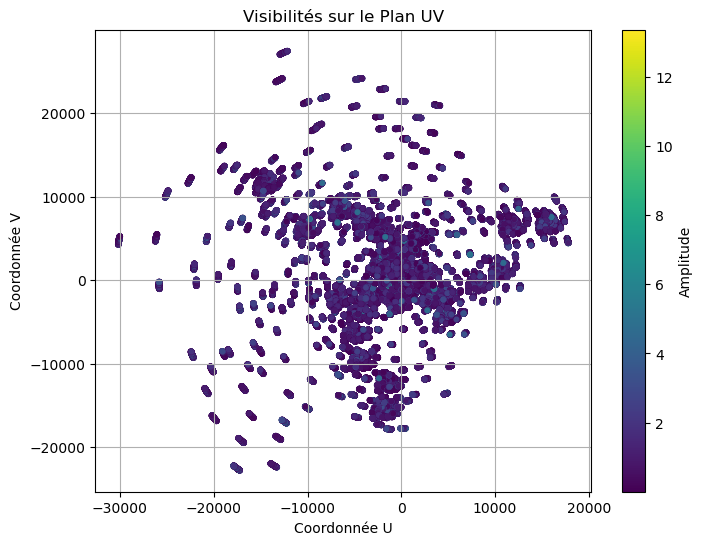

In [2]:
from plot_vis import plot_visibilities

plot_visibilities("../example/GLEAM_small_visibilities_corrupted.csv")

#### Step 1: run the custom script to generate a custom *.fits & Step 2: convert as csv

Fichier FITS généré : code/radioastro.fits


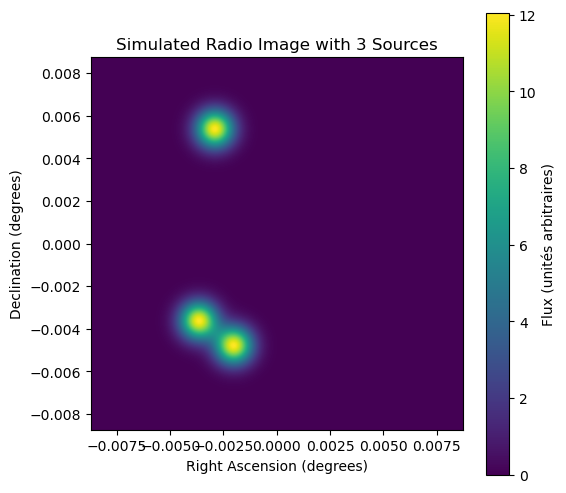

Fichier sauvegarder dans : code/image.csv


In [1]:
from fits_to_csv import generate_fits, generate_csv


GRID_SIZE = 512
NUM_SOURCES = 3

generate_fits(GRID_SIZE, NUM_SOURCES, "code/radioastro.fits")
generate_csv("code/radioastro.fits","code/image.csv")



#### Step 3: build degridding kernels

Dans les pipelines classique d'imagerie radio-interferometrique les kernels (ou noyaux) sont utilisé pour les convolutions sur les données. Les noyaux de gidding degridding sont des fonctions qui prennent en compte l'espacement des points de données et leur position relative sur la grille, et elles ajustent les valeurs des pixels de l'image pour correspondre aux signaux capturés par les antennes.

Ici, les noyaux sont utilisés pour simuler l'impact du réseau d'antennes sur l'image de sortie, en tenant compte de plusieurs facteurs comme :

1.    Projection spatiale : Le réseau interférométrique capte des signaux provenant de différentes positions dans l’espace. Les kernels sont utilisés pour projeter l'information contenue dans l'image (domaine spatial) sur les visibilités, en tenant compte des fréquences et des angles de vue des antennes.

2.    Transformation de Fourier : Les visibilités sont souvent obtenues par une transformation de Fourier des données, ce qui permet de passer du domaine spatial au domaine fréquentiel. Les kernels utilisés dans cette transformation permettent de modéliser comment les différentes fréquences (composantes de l'onde radio) sont captées par les antennes. Ces transformations sont souvent réalisées via des kernels de gridding, qui placent les données mesurées sur une grille régulière avant de les convertir en visibilités.

3.    Correction des distorsions : Les distorsions peuvent apparaître lors de la conversion des données spatiales vers les données fréquentielles. Les kernels sphéroïdaux ou d'autres types de filtres peuvent être utilisés pour éviter des artefacts comme le repliement des fréquences (aliasing) et garantir que les visibilités simulées sont réalistes.

Taille de la cellule de la grille: 7.03125 arcsec


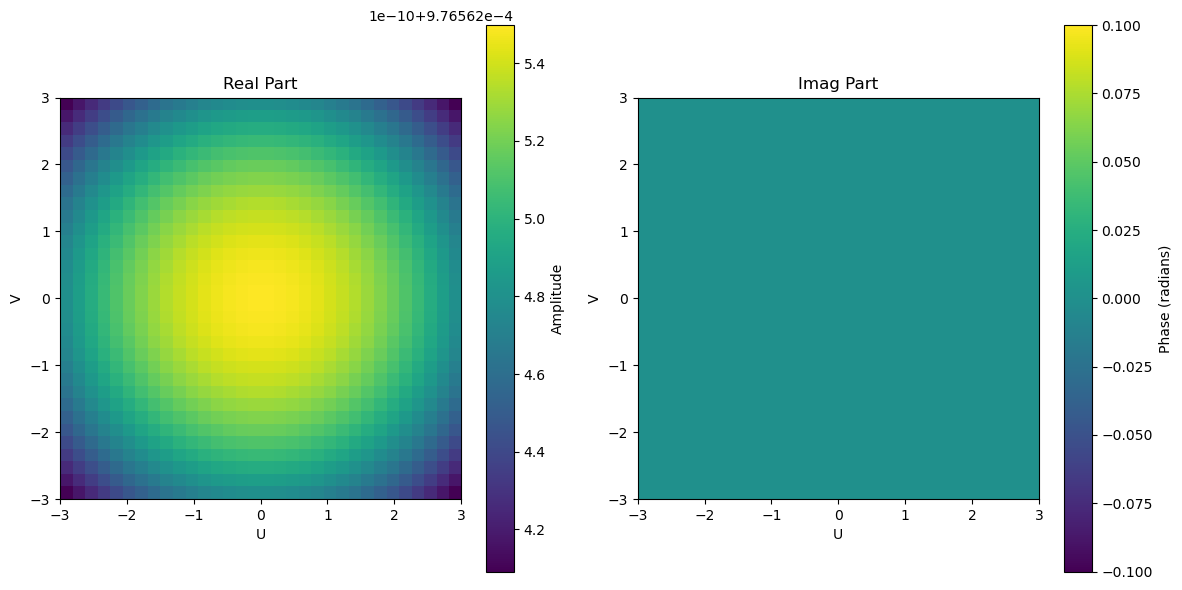

In [16]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

# Paramètres d'entrée
FOV_DEGREES = 1  # Champ de vue en degrés
GRID_SIZE = 512  # Taille de la grille I(l,m)
NUM_DEGRIDDING_KERNELS = 17  # Nombre de noyaux de degridding
OVERSAMPLING_FACTOR = 16  # Facteur de suréchantillonnage
KERNEL_SUPPORT = 6  # Taille du support du noyau en pixels
BETA = 2.0  # Paramètre de la fenêtre Kaiser-Bessel
WIDTH = 4.0  # Largeur du noyau
FREQUENCY_HZ = 1.4e9  # Fréquence en Hz (ex: 1.4 GHz)
BASELINE_MAX = 1000  # Distance maximale de la baseline en mètres
SPEED_OF_LIGHT = 3e8  # Vitesse de la lumière en m/s

# Calcul de la taille de la cellule en secondes d'arc
cell_size_arcsec = (FOV_DEGREES * 3600) / GRID_SIZE
print(f"Taille de la cellule de la grille: {cell_size_arcsec} arcsec")

def kaiser_bessel_kernel(u, beta=BETA, width=WIDTH):
    """ Génère un noyau Kaiser-Bessel pour le gridding et degridding."""
    arg = np.maximum(0, 1 - (2 * u / width) ** 2)  # Empêche les valeurs négatives
    kernel = np.where(arg > 0, sp.i0(beta * np.sqrt(arg)) / sp.i0(beta), 0)
    return kernel

def generate_gridding_kernel(grid_size=GRID_SIZE, num_kernels=NUM_DEGRIDDING_KERNELS, oversampling=OVERSAMPLING_FACTOR, kernel_support=KERNEL_SUPPORT, beta=BETA, width=WIDTH, baseline_max=BASELINE_MAX, frequency_hz=FREQUENCY_HZ):
    """ Génère une table de noyaux de gridding en 2D avec ajustement UV selon la fréquence et la baseline."""
    # Calcul de uvw_max
    uvw_max = baseline_max * frequency_hz / SPEED_OF_LIGHT
    
    # Définir les coordonnées U et V en fonction du support et de l'échantillonnage
    u = np.linspace(-kernel_support / 2, kernel_support / 2, grid_size // oversampling)
    v = np.linspace(-kernel_support / 2, kernel_support / 2, grid_size // oversampling)
    uu, vv = np.meshgrid(u, v)
    
    # Conversion en coordonnées UV en fonction de uvw_max
    uu = uu / uvw_max
    vv = vv / uvw_max
    
    r = np.sqrt(uu**2 + vv**2)
    kernel = kaiser_bessel_kernel(r, beta, width)
    kernel_complex = kernel + 1j * np.zeros_like(kernel)  # Partie réelle et imaginaire
    return kernel_complex / np.sum(kernel)  # Normalisation


def save_kernel_to_csv(kernel, filename_real="kernel_real.csv", filename_imag="kernel_imag.csv", filename_support="kernel_support.csv"):
    """ Sauvegarde la partie réelle, imaginaire et le support du noyau dans des fichiers CSV """
    real_part = np.real(kernel)
    imag_part = np.imag(kernel)
    support = np.indices(kernel.shape)[0]
    
    with open(filename_real, "w") as f_real, open(filename_imag, "w") as f_imag, open(filename_support, "w") as f_support:
        for i in range(kernel.shape[0]):
            for j in range(kernel.shape[1]):
                f_real.write(f"{real_part[i, j]},")
                f_imag.write(f"{imag_part[i, j]},")
                f_support.write(f"{support[i, j]},")
            f_real.write("\n")
            f_imag.write("\n")
            f_support.write("\n")

def plot_real_and_phase(kernel, title_real="Real Part", title_phase="Imag Part"):
    """ Affiche la partie réelle et la phase du noyau côte à côte """
    real_part = np.real(kernel)
    phase = np.angle(kernel)  # Phase en radians

    # Créer la figure avec deux sous-graphes côte à côte
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Afficher la partie réelle
    im_real = ax[0].imshow(real_part, extent=[-KERNEL_SUPPORT / 2, KERNEL_SUPPORT / 2, -KERNEL_SUPPORT / 2, KERNEL_SUPPORT / 2], cmap='viridis')
    ax[0].set_title(title_real)
    ax[0].set_xlabel("U")
    ax[0].set_ylabel("V")
    fig.colorbar(im_real, ax=ax[0], label="Amplitude")

    # Afficher la phase
    im_phase = ax[1].imshow(phase, extent=[-KERNEL_SUPPORT / 2, KERNEL_SUPPORT / 2, -KERNEL_SUPPORT / 2, KERNEL_SUPPORT / 2], cmap='viridis')
    ax[1].set_title(title_phase)
    ax[1].set_xlabel("U")
    ax[1].set_ylabel("V")
    fig.colorbar(im_phase, ax=ax[1], label="Phase (radians)")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    kernel = generate_gridding_kernel()
    plot_real_and_phase(kernel)
    save_kernel_to_csv(kernel)


#### Step 4: run the dataflow executable

In [2]:
import os
import subprocess

# Chemin vers le dossier dataflow
dataflow_directory = "code"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")

EXECUTABLE = "./STD_DEGRID"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run(EXECUTABLE, capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")

#Retourner d'où on vient    
os.chdir("..")
print(os.getcwd())



Le répertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code...
Lancement : ./STD_DEGRID
max_w: 4761.904762
w_scale: 0.053760
uv_scale: 0.017453
UPDATE >>> Image loaded from image.csv
Grille d'entrée 0: 0.000000 + 0.000000i
Grille d'entrée 1: 0.000000 + 0.000000i
Grille d'entrée 2: 0.000000 + 0.000000i
Grille d'entrée 3: 0.000000 + 0.000000i
Grille d'entrée 4: 0.000000 + 0.000000i
UPDATE >>> Loading degridding kernel support file from config/w-proj_supports_x16_2458_image.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is 108800...

UPDATE >>> Loading kernel files file from config/w-proj_kernels_real_x16_2458_image.csv real and config/w-proj_kernels_imag_x16_2458_image.csv imaginary...

kernel_supports 0: 4 + 0i
kernel_supports 1: 4 + 6400i
kernel_supports 2: 4 + 12800i
kernel_supports 3: 4 + 19200i
kernel_supports 4: 4 + 25600i
kernels 0: 0.187121 + 0.000000i
kernels 1: 0.186728 + -0.000001i
kernels 2:

#### Step 5: Visualize the generated visibilities

Min u : -998.369141, Max u : 1000.0
Min v : -999.592224, Max v : 999.592224
Min réel : 0.0, Max réel : 0.0
Min imaginaire : 0.0, Max imaginaire : 0.0
Maximum d'amplitude : 0.0


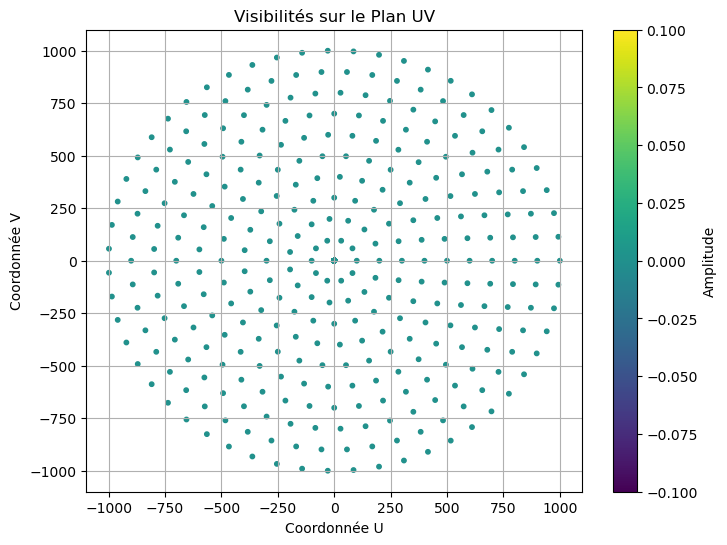

In [16]:
from plot_vis import plot_visibilities

plot_visibilities("code/vis.csv")

#### Step ++: compute psf

case PSF_GRID_SIZE > GRID_SIZE:
- The PSF will be truncated by our pipelines: only a central region of the PSF is copied to the image grid.
case PSF_GRID_SIZE < GRID_SIZE:
- The PSF will be placed at the center of the image grid, and values outside this area will remain zero.

| **PSF Parameter**     | **Impact on Reconstructed Image**                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------------|
| **Sigma (Width)**     | - Small sigma: Concentrated PSF, higher resolution but may amplify noise.                          |
|                       | - Large sigma: Spread PSF, reduces noise but also decreases resolution.                            |
| **Grid Size**         | - Small grid: PSF doesn't capture enough of the instrument's response.                            |
|                       | - Large grid: Can add artifacts or be unusable in convolution algorithms.                          |
| **PSF Shape**         | - Gaussian is commonly used, but more complex PSFs (Airy, Moffat, etc.) may better represent real optics. |
| **Normalization**     | - Normalizing to unity ensures energy conservation in convolution.                                |
|                       | - Incorrect normalization may introduce biases into the reconstructed image.                      |
| **Truncation**        | - Sharp truncation at the edges of the PSF grid may introduce artifacts in the reconstructed image. |
| **Symmetry**          | - Asymmetric PSF can cause distortions in the reconstructed image.                                |


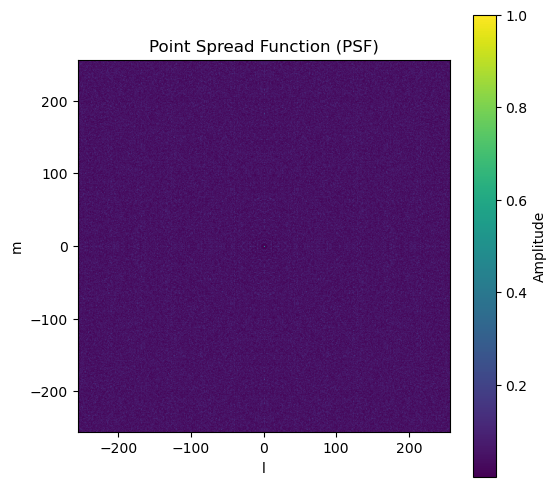

✅ PSF générée et exportée dans code_dft/data/input/psf.csv


In [17]:
from psf import generate_psf
GRID_SIZE = 512
sigma = 4
generate_psf(GRID_SIZE,"code/vis.csv","code_dft/data/input/psf.csv")


#### Step ++: Running GIP - DFT

In [18]:
import os
import subprocess

# Chemin vers le dossier du pipeline
dataflow_directory = "code_dft"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")

EXECUTABLE = "./SEP_Pipeline"

print(f"Lancement : {EXECUTABLE}")
result = subprocess.run([EXECUTABLE, "20000", "512", "50"], capture_output=True, text=True)
print(result.stdout)
if result.stderr:
    print(f"Erreur :\n{result.stderr}")
    
os.chdir("..")
print(os.getcwd())

Le répertoire actuel est /home/orenaud/Documents/GITHUB/VIS/vis-generator/dataflow_simulator. Changement vers code_dft...
Lancement : ./SEP_Pipeline
UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> PSF read from file with max value to scale grid = 1.000000...

UPDATE >>> Loading degridding kernel support file from data/input/kernels/new/wproj_manualconj_degridding_kernel_supports_x16.csv...

UPDATE >>> Total number of samples needed to store degridding kernels is 108800...

kernel_supports MD5 	: 78F8EAB1AE1FB097D8ED8FF27A7BC79F
UPDATE >>> Loading kernel files file from ../code/config/wproj_manualconj_degridding_kernels_real_x16.csv real and ../code/config/wproj_manualconj_degridding_kernels_imag_x16.csv imaginary...

UPDATE >>> Loa

#### Step ++: csv to fits

In [19]:
from csv_to_fits import *

input_directory = "code_dft/data/output/tune/"
output_directory = "code_dft/data/fits/"
delimiter = ","
convert_all_csv_in_directory(input_directory, output_directory, delimiter)

✅ Converted all CSV files from code_dft/data/output/tune/ to code_dft/data/fits/


#### Step++: visualizing the reconstructed image

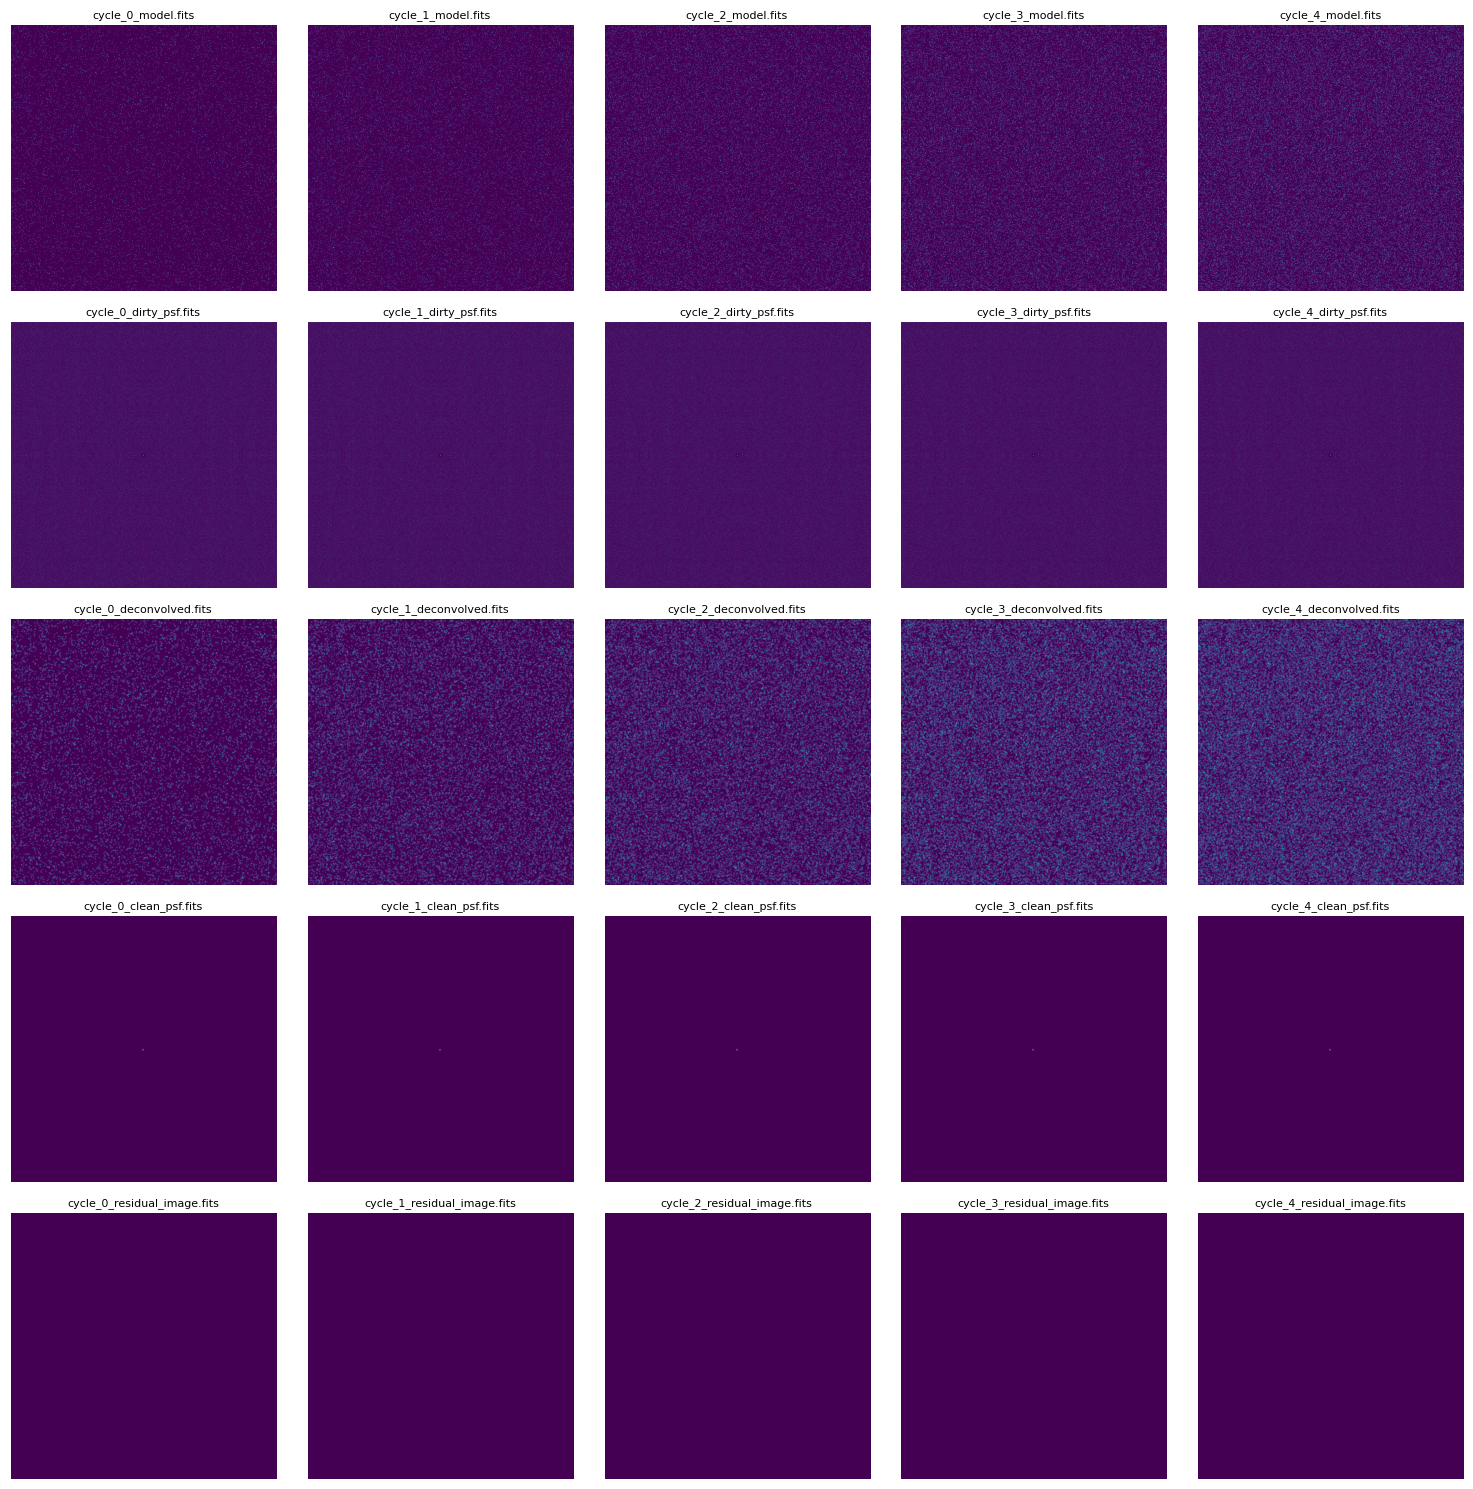

In [20]:
import os
import glob
from collections import deque
from astropy.io import fits
import matplotlib.pyplot as plt

NUM_MAJOR_CYCLE = 5

# Fonction pour afficher une image FITS dans une cellule
def display_fits_images(ax, fits_file):
    hdulist = fits.open(fits_file)
    data = hdulist[0].data
    hdulist.close()

    if data is not None:
        ax.imshow(data, cmap='viridis', origin='lower')
        ax.set_title(os.path.basename(fits_file), fontsize=8)
        ax.axis('off')


def display_images_by_type(base_dir, types):
    fig, axs = plt.subplots(len(types), NUM_MAJOR_CYCLE, figsize=(15, 3 * len(types)))  # NUM_MAJOR_CYCLE colonnes, 1 ligne par type
    
    for row, image_type in enumerate(types):
        # Trouver et trier les fichiers par cycle
        files = sorted(glob.glob(f"{base_dir}/*_{image_type}.fits"))
        
        for col in range(NUM_MAJOR_CYCLE):
            if col < len(files):
                display_fits_images(axs[row, col], files[col])
            else:
                axs[row, col].axis('off')  

    plt.tight_layout()
    plt.show()

base_dir = 'code_dft/data/fits'
types = ['model', 'dirty_psf', 'deconvolved', 'clean_psf', 'residual_image']

display_images_by_type(base_dir, types)

#### Step++: check quality

On est déjà dans le répertoire code_dft.


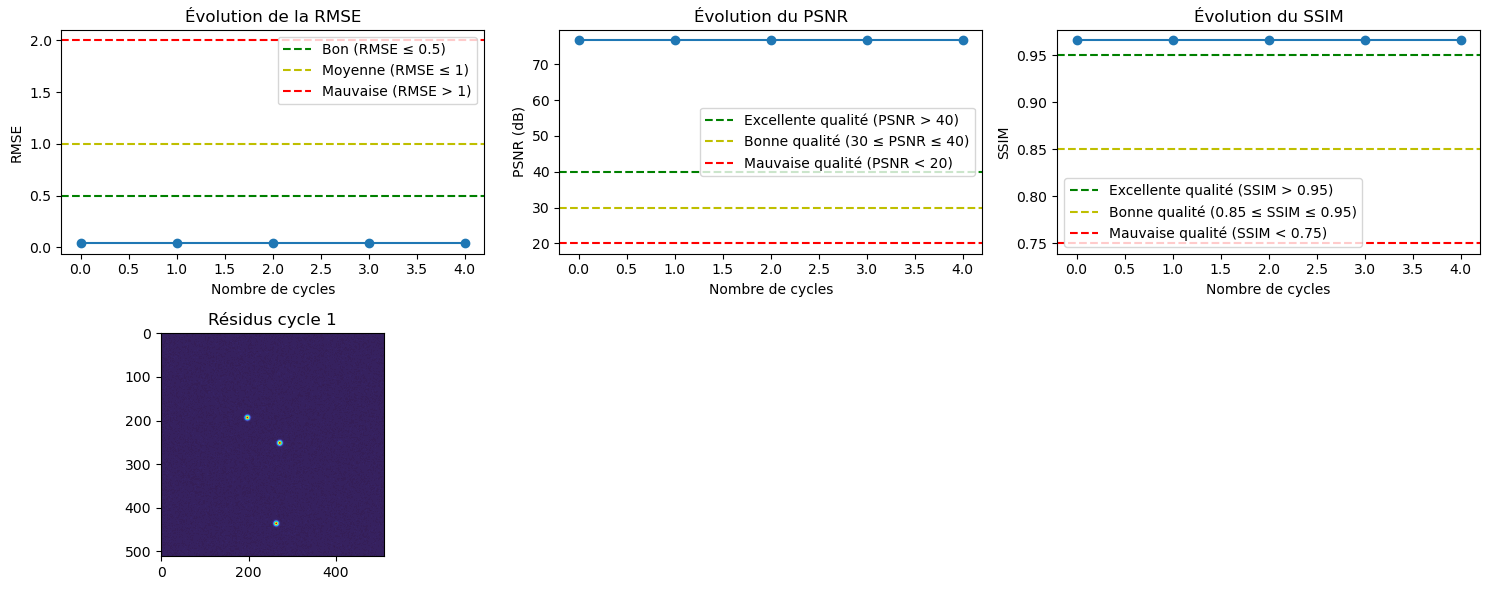

In [37]:
from astropy.io import fits
from skimage.metrics import structural_similarity as ssim
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from math import log10, sqrt


# 🔎 Fonction pour trier les fichiers par type dans un tableau ordonné
def get_sorted_files(base_dir, types):
    sorted_files = []
    for t in types:
        files = sorted(glob.glob(f"{base_dir}/*_{t}.fits"))[:5]
        sorted_files.append(files)
    return sorted_files

# 📏 Calcul de la RMSE
def calculate_rmse(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    # Calculer la RMSE
    rmse = np.sqrt(np.mean((reference_data - deconvolved_data) ** 2))
    
    return rmse

# 📈 Calcul du PSNR
def calculate_psnr(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    mse = np.mean((reference_data - deconvolved_data) ** 2)
    if mse == 0:
        return 100  # Pas d'erreur, les images sont identiques
    max_pixel = 255.0
    return 10 * log10((max_pixel ** 2) / mse)

# 🖼 Calcul du SSIM
def calculate_ssim(reference_image, deconvolved_image):
    # Charger les données des deux images FITS
    reference_data = reference_image[0].data
    deconvolved_data = deconvolved_image[0].data
    
    
    # Vérifier que les images ont la même taille
    if reference_data.shape != deconvolved_data.shape:
        # Retirer la dernière colonne de l'image déconvulée pour la mettre à la même taille que la référence
        deconvolved_data = deconvolved_data[:, 1:]
        
    return ssim(reference_data, deconvolved_data,data_range=reference_data.max() - reference_data.min())


# Chemin vers le dossier du degridder
dataflow_directory = "code_dft"

# Vérifie si on est déjà dans le bon dossier
current_directory = os.getcwd()
if not current_directory.endswith(dataflow_directory):
    print(f"Le répertoire actuel est {current_directory}. Changement vers {dataflow_directory}...")
    os.chdir(dataflow_directory)
else:
    print(f"On est déjà dans le répertoire {dataflow_directory}.")
    
reference = fits.open("../code/radioastro.fits")
sorted_files = get_sorted_files("data/fits", ["deconvolved"])  # Fichiers déconvulés
rmse_values = []
psnr_values = []
ssim_values = []

num_cycle = []
residuals = []

# Calcul de la RMSE pour chaque image déconvulée
for i, deconvolved_file in enumerate(sorted_files[0]):  
    num_cycle.append(i)
    deconvolved_image = fits.open(deconvolved_file)
    rmse_value = calculate_rmse(reference, deconvolved_image)
    rmse_values.append(rmse_value)
    psnr_value = calculate_psnr(reference,deconvolved_image)
    psnr_values.append(psnr_value)
    ssim_value = calculate_ssim(reference,deconvolved_image)
    ssim_values.append(ssim_value)
    residual = reference[0].data - deconvolved_image[0].data[:, 1:]
    residuals.append(residual)

    
    #print(f"RMSE pour l'image déconvulée {deconvolved_file}: {rmse_value}")

fig, axes = plt.subplots(2, 3, figsize=(15, 6))

# Graphique RMSE
axes[0, 0].plot(num_cycle, rmse_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour RMSE
axes[0, 0].axhline(y=0.5, color='g', linestyle='--', label='Bon (RMSE ≤ 0.5)')
axes[0, 0].axhline(y=1, color='y', linestyle='--', label='Moyenne (RMSE ≤ 1)')
axes[0, 0].axhline(y=2, color='r', linestyle='--', label='Mauvaise (RMSE > 1)')
axes[0, 0].set_xlabel('Nombre de cycles')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Évolution de la RMSE')
axes[0, 0].legend()

# Graphique PSNR
axes[0, 1].plot(num_cycle, psnr_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour PSNR
axes[0, 1].axhline(y=40, color='g', linestyle='--', label='Excellente qualité (PSNR > 40)')
axes[0, 1].axhline(y=30, color='y', linestyle='--', label='Bonne qualité (30 ≤ PSNR ≤ 40)')
axes[0, 1].axhline(y=20, color='r', linestyle='--', label='Mauvaise qualité (PSNR < 20)')
axes[0, 1].set_xlabel('Nombre de cycles')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].set_title('Évolution du PSNR')
axes[0, 1].legend()

# Graphique SSIM
axes[0, 2].plot(num_cycle, ssim_values, marker='o', linestyle='-', color='tab:blue')
# Définir les zones de qualité pour SSIM
axes[0, 2].axhline(y=0.95, color='g', linestyle='--', label='Excellente qualité (SSIM > 0.95)')
axes[0, 2].axhline(y=0.85, color='y', linestyle='--', label='Bonne qualité (0.85 ≤ SSIM ≤ 0.95)')
axes[0, 2].axhline(y=0.75, color='r', linestyle='--', label='Mauvaise qualité (SSIM < 0.75)')
axes[0, 2].set_xlabel('Nombre de cycles')
axes[0, 2].set_ylabel('SSIM')
axes[0, 2].set_title('Évolution du SSIM')
axes[0, 2].legend()

# Affichage des résidus
axes[1, 0].imshow(residuals[0], cmap='turbo')
axes[1, 0].set_title("Résidus cycle 1")

# Suppression des axes vides (si nécessaire)
axes[1, 1].axis('off')
axes[1, 2].axis('off')


plt.tight_layout()
plt.show()
